In [1]:
#import packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import astropy.io.fits as fits
import glob
import os
import pyklip
import pyklip.klip as klip
from pyklip.fmlib.diskfm import DiskFM
import pyklip.fm as fm
import pyklip.parallelized as parallelized
from pyklip.kpp.utils.mathfunc import *
from pyklip.kpp.metrics.crossCorr import calculate_cc
from pyklip.instruments.Instrument import GenericData
import pyklip.instruments.NIRC2 as NIRC2
import astropy.units as u
from pyklip.kpp.stat.stat_utils import get_image_stat_map
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from photutils.centroids import centroid_2dg
import warnings
import pyklip.fm as fm
import pyklip.fmlib.fmpsf as fmpsf
import pyklip.fitpsf as fitpsf
import pyklip.fakes as fakes
from astropy.modeling import models, fitting
import math
import lmfit
%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
#gaussian model generator for FM planet PSF
def makeGaussian(size, amplitude = 1, fwhm = 3, center=None):
    #from andrewgiessel on github

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return amplitude * np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

def fitPrimary(x0, y0, im, radius=10, xIndex=None, yIndex=None,
               weight=None, mask=None,
               returnModel=False):
    """
    fit a 2d gaussian to the region of interest and return the fitted x and y
    """
    if xIndex is None:
        xIndex = np.arange(im.shape[1]).astype(int)
    if yIndex is None:
        yIndex = np.arange(im.shape[0]).astype(int)

    subXIndex, = np.where(np.abs(xIndex - x0) < radius)
    subYIndex, = np.where(np.abs(yIndex - y0) < radius)

    yyIndex, xxIndex = np.meshgrid(subYIndex, subXIndex,
                                   indexing='ij')
    yy, xx = np.meshgrid(yIndex[subYIndex], xIndex[subXIndex],
                         indexing='ij')

    subim = im[yyIndex.astype(int), xxIndex.astype(int)]

    if weight is None:
        subweight = np.ones_like(subim)
    else:
        subweight = weight[subYIndex, subXIndex]

    if mask is None:
        mask = np.zeros_like(subim)
    else:
        # if there are masked pixel, set the corresponding pixels' weight to 0
        weight[np.where(mask) != 0] = 0
    p = Parameters()
    p.add('g_centerx', value=x0)
    p.add('g_centery', value=y0)
    p.add('g_amplitude', value=np.nanmax(subim))
    p.add('g_sigmax', value=1, min=0)
    p.add('g_sigmay', value=1, min=0)
    p.add('c_c', value = 0)
    pFit = gModel.fit(subim, params=p, x=xx, y=yy, weights=subweight,
                      verbose=True,
                      method='powell',
                      nan_policy='omit')
    modelImage = np.zeros_like(im) 
    modelImage[yyIndex.astype(int), xxIndex.astype(int)] = pFit.best_fit.reshape(yy.shape) 

    print(pFit.fit_report())
    return pFit, modelImage

[611.24866484 434.90057212]
Gaussian
(31, 1024, 1024)
(15, 15)
Begin align and scale images for each wavelength
Align and scale finished
Starting KLIP for sector 1/3 with an area of 258191.18849283783 pix^2
Time spent on last sector: 0s
Time spent since beginning: 0s
First sector: Can't predict remaining time
 100.00% of sector, 33.33% of total completed
Starting KLIP for sector 2/3 with an area of 753406.1392865535 pix^2
Time spent on last sector: 120s
Time spent since beginning: 120s
Estimated remaining time: 927s
Average time per pixel: 0.0004630177352284009 during last sector, 0.0004630177352284009 since begining
 100.00% of sector, 66.67% of total completed
Starting KLIP for sector 3/3 with an area of 1248621.090080269 pix^2
Time spent on last sector: 224s
Time spent since beginning: 344s
Estimated remaining time: 424s
Average time per pixel: 0.00029757910466171784 during last sector, 0.0003398042030043606 since begining
 100.00% of sector, 100.00% of total completed
Closing threa

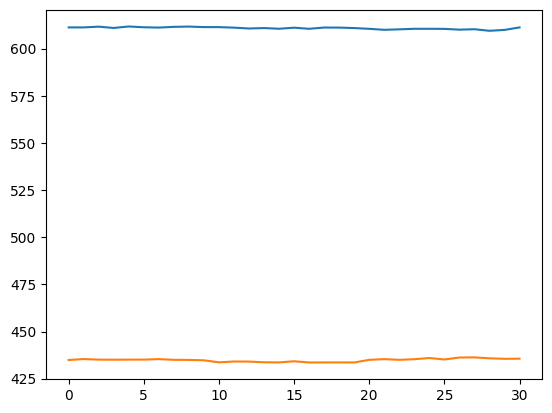

In [8]:
#returns median of aligned images to use as PSF
def ADI_psfs(psflist): 
    rawpsfs = np.zeros((len(psflist), 1024, 1024))
    adjustedpsfs = np.zeros((len(psflist), 1024, 1024))
    alignedpsfs = np.zeros((len(psflist), 1024, 1024))
    #shiftentries = (701-60, 487-32)
    for i in range(len(psflist)):
        rawpsfs[i,0:120,0:64] = fits.getdata(psflist[i])
        adjustedpsfs[i, 701-60:701+60,487-32:487+32] = rawpsfs[i,0:120,0:64] // 3000 #normalize to background of zeroes, values used to be order of millions
        #adjustedpsfs[i,:,:] = fourier_shift(rawpsfs[i,:,:], shiftentries)
        if i != 0:
            shifts, error, diffphase = phase_cross_correlation(alignedpsfs[0,:,:], adjustedpsfs[i,:,:], upsample_factor=100)
            alignedpsfs[i,:,:] = fourier_shift(adjustedpsfs[i,:,:], shifts)
        else:
            alignedpsfs[0,:,:] = adjustedpsfs[0,:,:]
            
    medpsfs = np.nanmedian(alignedpsfs, axis=0)

    
    return np.array([medpsfs])

    



#returns fits-processed images, centers, and parallactic angles for every file in the list with given dimensions
def ADI_getImages(flist, xdim, ydim):
    rawcube = np.zeros((len(flist),xdim,ydim))
    ctrs= np.zeros((len(flist),2))
    parangs = np.zeros((len(flist)))
    
    boxrad = 4
    cx, cy = 610,436
    b, t, l, r = cy - boxrad, cy + boxrad, cx - boxrad, cx + boxrad
    threshold = 5.5
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        #find centers
        
        ctrs[i] = (l, b) + centroid_2dg(rawcube[i,b:t,l:r])
        
        if ctrs[i][0] > r or ctrs[i][0] < l or ctrs[i][1] > t or ctrs[i][1] < b:
            shift, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:], upsample_factor=100, normalization=None)
            ctrs[i] = ctrs[0] - shift

        # if i > 0:
        #     movement = abs(ctrs[i][1] - ctrs[i-1][1]) + abs(ctrs[i][0] - ctrs[i-1][0])
        #     if i != 10 and movement > threshold:
        #         print(i, movement)
        #         ctrs[i] = ctrs[i - 1]
        # if i == 0:
        #     print(b, t, l, r)
        #     ctrs[i] = (l, b) + centroid_2dg(rawcube[0,b:t,l:r])
            
        #                                                 #12_2023_H: 612, 435.7
        #                                               #12_2023_CH4s: 598.5, 454
        #                                               #12_2023_CH4l: 598.9, 454.2
        #                                               #12_2023_J: 612, 436.3
        #                                               #12_2023_Ks: 617, 429
        #                                               #02_2023_H: 612.8, 433.9
        #                                               #04_2021_CH4s: 600, 453
            
        # else:
        #     shifts, error, diffphase, = phase_cross_correlation(rawcube[0,:,:],rawcube[i,:,:],
        #                                             upsample_factor=100,
        #                                             normalization=None)
        #     ctrs[i] = ctrs[0] - shifts
            
        parangs[i] = head['PARANG']

    # ydat, xdat = np.indices(rawcube[0].shape)
    # for i in range(len(flist)):
    #     rawTemp = np.copy(rawcube[i])
    #     cx, cy = ctrs[i]

    #     rawTemp[int(cy),int(cx)] = np.nan
    #     fits.writeto(f'../rawPlusCenters/2023_12_J/new{i}.fits', rawTemp, overwrite=True)
        
    #     rawTemp[b,l:r], rawTemp[t,l:r], rawTemp[b:t, l], rawTemp[b:t, r] = np.nan, np.nan, np.nan, np.nan
    #     distance_from_center = np.sqrt((xdat - cx)**2 + (ydat-cy)**2)
    #     rawTemp[np.where(distance_from_center <= 3)] = np.nan
    #     fits.writeto(f'../rawPlusCenters/2023_12_J/n{i}.fits', rawTemp, overwrite=True)
    
    # distance_from_center = np.sqrt((xdat - ctrs[0][0])**2 + (ydat-ctrs[0][1])**2)
    # medcube = np.nanmedian(rawcube, axis=0)
    # newMedCube = np.copy(medcube)
    # newMedCube[np.where(distance_from_center <= 3)] = np.nan
    # fits.writeto('medIMG.fits', newMedCube, overwrite=True)
    
    # tempCube = np.copy(rawcube[0,:,:])
    # tempCube[np.where(distance_from_center <= 3)] = np.nan
    # fits.writeto('rawIMG.fits', tempCube, overwrite=True)

    # cx, cy = int(ctrs[0][0]), int(ctrs[0][1])
    # b, t, l, r = cy - boxrad, cy + boxrad, cx - boxrad, cx + boxrad
    # print(cx, cy, b, t, l, r)
    # centroid = centroid_2dg(medcube[b:t, l:r])
    # print(centroid)
    # distance_from_center_2 = np.sqrt((xdat - l - centroid[0])**2 + (ydat - b - centroid[1])**2)
    # tempCube2 = np.copy(medcube)
    # tempCube2[np.where(distance_from_center_2 <= 3)] = np.nan
    # tempCube2[b,l:r], tempCube2[t,l:r], tempCube2[b:t, l], tempCube2[b:t, r] = np.nan, np.nan, np.nan, np.nan
    # fits.writeto('centroidIMG.fits', tempCube2, overwrite=True)
    
    plt.plot(ctrs)
    return rawcube, ctrs, parangs
        
    
#classical ADI
def cADI_NIRC2(flist):
    
    rawcube = np.zeros((len(flist),1024,1024))
    aligned_cube = np.zeros((len(flist),1024,1024))
    cccube = np.zeros((1024,1024))
    subcube = np.zeros((len(flist),1024,1024))
    derotcube = np.zeros((len(flist),1024,1024))
    SNR_map = np.zeros((1024,1024))     
    ctrs=[]
    ctrPoisson = []
    vertangs = []
    x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
    kernel_gauss = gauss2d(x_grid,y_grid, amplitude = 40.0, xo = 0, yo = 0, sigma_x = .5, sigma_y = .5)
    
    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        head = fits.getheader(flist[i],ext=0)
        
        if i == 0:
            #ctrs.append((609, 436) + centroid_2dg(rawcube[0,609:613,436:442],error=None,mask=None)) #for Feb_2023
            #ctrs.append((605,430) + centroid_2dg(rawcube[0,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append((611.4,436.2))
            
            aligned_cube[0,:,:] = rawcube[0,:,:]
        else:              
            shifts, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:],upsample_factor=100,normalization=None)
            aligned_cube[i,:,:] = fourier_shift(rawcube[i,:,:],shifts)
            #ctrs.append((609, 436) + centroid_2dg(rawcube[i,609:613,436:442],error=None,mask=None)) #for Feb_2023
            ctrs.append((605,430) + centroid_2dg(aligned_cube[i,605:620,430:440],error=None,mask=None)) #for Dec_2023
            ctrPoisson.append(ctrPoisson[0]+shifts)
        va = head['ROTPOSN'] - head['INSTANGL'] + head['PARANG']
        vertangs.append(va)

    fits.writeto('tempstar.fits',aligned_cube[1,:,:],overwrite=True)
    medcube = np.nanmedian(aligned_cube,axis=0)
    
    for i in np.arange(len(flist)):
        subcube[i,:,:] = aligned_cube[i,:,:] - medcube
        derotcube[i,:,:] = klip.rotate(subcube[i,:,:], vertangs[i], ctrPoisson[i]) ##check tutorial
        
        
    med_derot = np.nanmedian(derotcube, axis=0)
    cccube[:,:] = calculate_cc(med_derot[:,:],kernel_gauss,spectrum=None,nans2zero=True)
    SNR_map[:,:] = get_image_stat_map(cccube,
                                               centroid = ctrPoisson[0],
                                               r_step=.5,
                                               Dr = .5,
                                               type = "SNR")
    
    plt.plot(ctrPoisson)
    plt.show()
    plt.plot(vertangs)
    plt.show()
    
    fits.writeto('med_derotcube.fits',med_derot,overwrite=True)
    fits.writeto('snr_cccube.fits',SNR_map,overwrite=True)
    
    return SNR_map, med_derot, ctrs[0]


#ADI
def ADI_NIRC2(flist):
    rawcube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
            
    dataset = GenericData(rawcube, ctrs, IWA=6, parangs=parangs)
    sub_imgs = parallelized.klip_dataset(dataset, outputdir='../klipdata/2023_02_H',
                                        annuli=9,subsections=4,numbasis=[1,7,15,30],maxnumbasis=150,mode="ADI",
                                        movement=1)

    return sub_imgs, ctrs[0]


#fake planet injection for contrast calibration
def injectFakePlanets(flist, stellar_flux):
    datacube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
    dataset = GenericData(datacube, ctrs, IWA=6  , parangs=parangs)
    
    input_planet_fluxes = [1e-6, 2e-7, 4e-8, 8e-9]
    seps = [100, 200, 300, 400]
    fwhm = 2.5

    for input_planet_flux, sep in zip(input_planet_fluxes, seps):
        injected_flux = input_planet_flux * stellar_flux
        for pa in [0, 90, 180, 270]:
            fakes.inject_planet(dataset.input, dataset.centers, injected_flux, dataset.wcs, sep, pa, fwhm=fwhm)

    parallelized.klip_dataset(dataset, outputdir='../klipdata/2023_12_CH4short', fileprefix='fakes',
                              annuli=9, subsections=4, numbasis=[1,20,50,100], calibrate_flux=True,
                              mode='ADI')
    return input_planet_fluxes, seps, dataset.wcs

#Forward-Modeling
def forwardmodel(flist, psflist=None, gaussian=None, fwhm=3):
    datacube, ctrs, parangs = ADI_getImages(flist, 1024, 1024)
    dataset = GenericData(datacube, ctrs, IWA=6, parangs=parangs)

    print(ctrs[0])
    
    numbasis = np.array([1, 20, 50, 100])
    guesssep = 191.5
    guesspa = 7.8
    # guesspa = 7.3        #for 2023_02_H
    guessflux = 1.0

    if len(gaussian) > 0:
        print('Gaussian')
        fm_psf_stamp = gaussian
        fits.writeto('gaussian_model.fits', fm_psf_stamp, overwrite=True)
    elif len(psflist) > 0:
        print('PSF')
        instrument_psfs = ADI_psfs(psflist)
        fm_psf_stamp = instrument_psfs[0, 691:711, 477:497]
        fits.writeto('psf_stamp.fits', fm_psf_stamp, overwrite=True)
    else:
        return

    print(datacube.shape)
    print(fm_psf_stamp.shape)
    fm_psf_stamp = fm_psf_stamp.reshape(1, fm_psf_stamp.shape[0], fm_psf_stamp.shape[1])

    fm_class = fmpsf.FMPlanetPSF(fm_psf_stamp.shape, numbasis, guesssep, guesspa, guessflux, fm_psf_stamp,
                             input_wvs = np.unique(dataset.wvs), flux_conversion = [1]*datacube.shape[0])

    outputdir = f"../fmdata/FM_2023_{band}"

    """   ___CHANGE THIS___   """
    
    prefix = f'fwhm={fwhm}'
    annulus_bounds = [[guesssep-15, guesssep+15]] 
    subsections = 1 
    padding = 0
    movement = 4

    fm.klip_dataset(dataset, fm_class, outputdir=outputdir, fileprefix=prefix, numbasis=numbasis,
                annuli=3, subsections=subsections, padding=padding, movement=movement)
    
#   ___CHANGE THIS___   """

band = '12_J'
datadir = f'../rawdata/2023_{band}/'
flist = sorted(glob.glob(datadir + '*.fits'), reverse=True)
#psflist = sorted(glob.glob(psfdir + '*.fits'))

fwhms = {
    '02_H': 5.417,
    '12_Kshort': 4.941,
    '12_CH4short': 3.866,
    '12_J': 6.004
}

gaussian = makeGaussian(size=15, amplitude=30, fwhm=fwhms[band])
gaussian_base_signal = np.matrix.sum(np.matrix(gaussian))
forwardmodel(flist, gaussian=gaussian, fwhm=fwhms[band])

# for val in fwhm:
#     gaussian = makeGaussian(size=120, amplitude=30, fwhm=val)
#     #fits.writeto('gaussian_psf.fits', gaussian, overwrite=True)
#     gaussian_base_signal = np.matrix.sum(np.matrix(gaussian))
#     forwardmodel(flist, gaussian=gaussian, fwhm=val)


#ADI_getImages(flist, 1024, 1024)
    #2023_12_H a=30 fwhm=5
    #2023_12_J a=60 fwhm=4
    #2023_12_CH4short a=60 fwhm=4
    #2023_12_Kshort a=25 fwhm=5
    #2023_02_H a=125 fwhm=4

#flist_adi, cen = ADI_NIRC2(flist)
#diskForwardmodel(flist, psflist)
#forwardmodel(flist, psflist)
#ADI_getImages(flist, 1024, 1024)
#ADI_NIRC2(flist)
#cADI_NIRC2(flist)
# forwardmodel(flist, gaussian=gaussian)
#flist_adi, cen = ADI_NIRC2(flist)
#input_planet_fluxes, seps, wcs = injectFakePlanets(flist, 179300000)

Running burn in
Burn in finished. Now sampling posterior
MCMC sampler has finished
Raw X/Y Centroid = (26.751819172828732, 189.56883073288327) with statistical error of [-0.16531713  0.16001237] pix in X and [-0.19779575  0.18975867] pix in Y
Raw Sep/PA Centroid = (191.44658441509404, 8.032879431088814) with statistical error of [ 0.19121581 -0.19892622] pix in Sep and [ 0.04859995 -0.04746198] pix in PA
Adding in star center uncertainity
Converting pixels to milliarcseconds
Adding in plate scale error
Adding in a PA/North angle offset
Adding in PA uncertainity
Sep = 191.44658441509404 +/- 0.2013792854517772 ([0.19764485 0.20511372]) pix, PA = 8.032879431088816 +/- 0.13939575927819536 ([0.13959181 0.13919971]) degrees
Sep = 1.9089138932029028 +/- 0.0021490647942867553 ([0.00211427 0.00218386]) mas, PA = 8.032879431088816 +/- 0.13939575927819536 ([0.13959181 0.13919971]) degrees
RA offset = 26.75181917282879 +/- 0.4625662203098092 ([0.46349895 0.46163349]) pix
Dec offset = 189.568830732

<Figure size 1000x800 with 0 Axes>

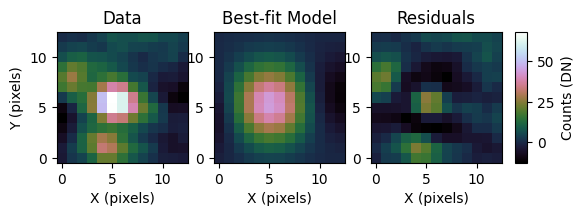

In [9]:
def processFMObject(output_prefix):
    #next step:
    #exposure time comparison, adjust psfs vs planet images because its measured in absolute counts
    # read in outputs
    fm_hdu = fits.open(output_prefix + "-fmpsf-KLmodes-all.fits")
    data_hdu = fits.open(output_prefix + "-klipped-KLmodes-all.fits")
    
    # get FM frame
    fm_frame = fm_hdu[0].data[1]
    fm_centx = fm_hdu[0].header['PSFCENTX']
    fm_centy = fm_hdu[0].header['PSFCENTY']
    
    # get data_stamp frame
    data_frame = data_hdu[0].data[1]
    data_centx = data_hdu[0].header["PSFCENTX"]
    data_centy = data_hdu[0].header["PSFCENTY"]
    
    # get initial guesses
    guesssep = fm_hdu[0].header['FM_SEP']
    guesspa = fm_hdu[0].header['FM_PA']

    fit = fitpsf.FMAstrometry(guesssep, guesspa, 13, method="mcmc")
    fit.generate_fm_stamp(fm_frame, [fm_centx, fm_centy], padding=5)
    fit.generate_data_stamp(data_frame, [data_centx, data_centy], dr=4, exclusion_radius=10)
    corr_len_guess = 3.
    corr_len_label = r"$l$"
    fit.set_kernel("matern32", [corr_len_guess], [corr_len_label])
    # set bounds
    x_range = 1.5 # pixels
    y_range = 1.5 # pixels
    flux_range = 1. # flux can vary by an order of magnitude
    corr_len_range = 1. # between 0.3 and 30
    fit.set_bounds(x_range, y_range, flux_range, [corr_len_range])
    
    
    # run MCMC fit
    fit.fit_astrometry(nwalkers=100, nburn=200, nsteps=800, numthreads=1)
    fig = pylab.figure(figsize=(10,8))
    
    # # grab the chains from the sampler
    # chain = fit.sampler.chain
    
    # # plot RA offset
    # ax1 = fig.add_subplot(411)
    # ax1.plot(chain[:,:,0].T, '-', color='k', alpha=0.3)

    # ax1.set_xlabel("Steps")
    # ax1.set_ylabel(r"$\Delta$ RA")
    
    # # plot Dec offset
    # ax2 = fig.add_subplot(412)
    # ax2.plot(chain[:,:,1].T, '-', color='k', alpha=0.3)
    # ax2.set_xlabel("Steps")
    # ax2.set_ylabel(r"$\Delta$ Dec")
    
    # # plot flux scaling
    # ax3 = fig.add_subplot(413)
    # ax3.plot(chain[:,:,2].T, '-', color='k', alpha=0.3)
    # ax3.set_xlabel("Steps")
    # ax3.set_ylabel(r"$\alpha$")
    
    # # plot hyperparameters.. we only have one for this example: the correlation length
    # ax4 = fig.add_subplot(414)
    # ax4.plot(chain[:,:,3].T, '-', color='k', alpha=0.3)
    # ax4.set_xlabel("Steps")
    # ax4.set_ylabel(r"$l$")

    # fig = pylab.figure()
    # fig = fit.make_corner_plot(fig=fig)

    fig = pylab.figure()
    fig = fit.best_fit_and_residuals(fig=fig)

    # print(fig)

    # # get residuals
    # print(fit.fit_flux.bestfit)
    # print(fit.fit_x.bestfit, fit.fit_y.bestfit)
    # print(fit.data_stamp_x_center, fit.data_stamp_y_center)
    # print(fit.fm_stamp)

    # dx, dy = fit.fit_x.bestfit - fit.data_stamp_x_center, fit.fit_y.bestfit - fit.data_stamp_y_center
    # fm_bestfit = fit.fit_flux.bestfit * sinterp.shift(fit.fm_stamp, [dy, dx])

    # print(fit.fit_x.bestfit, fit.fit_y.bestfit)
    # print(dx, dy)
    # img = fit.data_stamp - fm_bestfit[5:-5, 5:-5]#float(fm_bestfit[5:-5, 5:-5])
    # stampcx, stampcy = fit.fit_x.bestfit - 5, fit.fit_y.bestfit - 5
    # central_residuals = np.matrix(img[2:-4, 2:-4]).astype(np.float32)
    # central_residuals = central_residuals ** 2
    # fits.writeto('bestfit.fits', np.matrix(fm_bestfit[5:-5, 5:-5]).astype(np.float32), overwrite=True)
    # fits.writeto('residual_test.fits', central_residuals, overwrite=True)
    # print(np.matrix.sum(np.matrix(img[]).astype(np.float32)))
    # fits.writeto('residual_test.fits', img, overwrite=True) 
    
    fit.propogate_errs(star_center_err=0.05, platescale=.009971, platescale_err=0.000004, pa_offset=0.0, pa_uncertainty=0.13)

    # print("\nPlanet Raw RA offset is {0} +/- {1}, Raw Dec offset is {2} +/- {3}".format(fit.raw_RA_offset.bestfit, fit.raw_RA_offset.error,
    #                                                                                     fit.raw_Dec_offset.bestfit, fit.raw_Dec_offset.error))
    
    # # Full error budget included
    # print("Planet RA offset is at {0} with a 1-sigma uncertainity of {1}".format(fit.RA_offset.bestfit, fit.RA_offset.error))
    # print("Planet Dec offset is at {0} with a 1-sigma uncertainity of {1}".format(fit.Dec_offset.bestfit, fit.Dec_offset.error))
    
    # # Propogate errors into separation and PA space
    # print("Planet separation is at {0} with a 1-sigma uncertainity of {1}".format(fit.sep.bestfit, fit.sep.error))
    # print("Planet PA at {0} with a 1-sigma uncertainity of {1}".format(fit.PA.bestfit, fit.PA.error))

    # # Propagate errors into flux/alpha
    print("Planet flux scaler value (alpha) is at {0} with a 1-sigma uncertainty of {1}".format(fit.fit_flux.bestfit, fit.fit_flux.error))
    # np.matrix.sum(np.matrix(fm_bestfit).astype(np.float32)),, np.matrix.sum(central_residuals.astype(np.float32))
    return fit.fit_flux.bestfit

def makeGaussian(size, amplitude = 1, fwhm = 3, center=None):
    #from andrewgiessel on github

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return amplitude * np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    
"""   ___CHANGE THIS___   """

alpha_flux = processFMObject('../fmdata/FM_2023_12_J/fwhm=6.004')
# print(alpha_flux * gaussian_base_signal)

# x = [4, 5, 5.5, 6, 7]
# residual_fluxes = []
# fluxes = []
# alphas = []
# for band in ['12_H', '12_J', '02_H']:
#     for i in x:
#         print('fwhm =', i)
#         psf_flux = np.matrix.sum(np.matrix(makeGaussian(size=120, amplitude=30, fwhm=i)))
#         alpha_flux, total_flux, residuals = processFMObject(output_prefix + f'{band}/fwhm={i}')
#         residual_fluxes.append(residuals)
#         fluxes.append(total_flux)
#         alpha = alpha_flux * psf_flux
#         alphas.append(alpha_flux)
#         print(total_flux, alpha_flux * psf_flux)   # (!) which of these values is right? does it make a difference?

In [10]:
#calculate contrast

from scipy.ndimage import shift

#take in star data
def starData(band):
    
    star_path = f'../stardata/2023_{band}/*.fits'
    flist = sorted(glob.glob(star_path))
    
    # 20x20 slice containing brightest features of the star
    # aligned via centroid_2dg and shifting, then taking the sum of the median
    n = len(flist)
    rawcube = np.zeros((n, 15, 15))
    alignedcube = np.zeros((n, 15, 15))
    ctrs = []

    # print(fits.getheader(flist[0]))
    
    for i in range(n):
        rawcube[i,:,:] = fits.getdata(flist[i])[50:65,25:40]
        if band == '12_H':
            rawcube[i,:,:] = fits.getdata(flist[i])[55:70,22:37]
        if band == '02_H':
            rawcube[i,:,:] = fits.getdata(flist[i])[123:138, 88:103]
        if band == '12_Kshort':
            if i >= 20:
                rawcube[i,:,:] = fits.getdata(flist[i])[39:54,22:37]
            else:
                rawcube[i,:,:] = fits.getdata(flist[i])[51:66,27:42]
        if band == '12_CH4short':
            if i >= 10:
                rawcube[i,:,:] = fits.getdata(flist[i])[54:69,22:37]
            else:
                rawcube[i,:,:] = fits.getdata(flist[i])[59:74,10:25]

        ctrs.append(centroid_2dg(rawcube[i]))
        alignedcube[i,:,:] = shift(rawcube[i,:,:],shift=ctrs[i] - ctrs[0],mode='grid-constant')

    medcube = np.nanmedian(alignedcube, axis=0)
    print(medcube[0][0])
    print(medcube.shape)
    # print(max(medcube))
    fits.writeto(f'medstar-{band}.fits', medcube, overwrite=True)
    # lmFitGaussian(medcube)
    return np.sum(medcube), medcube


def contrast(band):

    # band: [flux scaler, flux scaler error]
    alphas = {
        '12_H': [2.141395, 0.0725038],
        '12_J': [1.514223, 0.0970178],
        '12_Kshort': [1.129825, 0.0764418],
        '02_H': [17.409384, 1.042479],
        '12_CH4short': [2.457822, 0.0913941]
    }

    # band : truitime * num_coadds
    time = {
        '12_H': 7.9965 * 4,
        '12_J': 9.99671 * 3,
        '12_Kshort': 9.99671 * 3,
        '02_H': 10 * 3,
        '12_CH4short': 10 * 3
    }

    # star and planet fluxes in counts
    _, star_img = starData(band)
    pFit, best_im = fitPrimary(7, 7, star_img, radius=8, returnModel=True)
    star_counts = np.sum(best_im)
    planet_counts = alphas[band][0] * gaussian_base_signal

    # convert to fluxes by dividing by sampling rate
    planet_flux = planet_counts / time[band]
    # star_flux = star_counts / (100 * 0.0100113)
    star_flux = star_counts / (100 * 0.014)

    print('\nPre Conversion:')
    print(star_counts, planet_counts)

    print('\nPost Conversion:')
    print(star_flux, planet_flux)
    
    contrast = planet_flux / star_flux
    contrast_mag = math.log(contrast, 10) * -2.51

    return contrast, contrast_mag




import numpy as np
from lmfit import Model, Parameters
from lmfit.models import Gaussian2dModel, ConstantModel
from astropy.io import fits


gModel = Gaussian2dModel(prefix='g_') + ConstantModel(prefix='c_')


#map bands to apparent magnitude of HD47127
appmag = {
    '12_H': 5.277,
    '12_J': 5.561,
    '12_Kshort': 5.174,
    '02_H': 5.277,
    '12_CH4short': 5 #placeholder
}

distance = 26.6

band = '12_J'
contrast_ratio, contrast_mag = contrast(band)

apparent_magnitude = contrast_mag + appmag[band]
absolute_magnitude = apparent_magnitude - 5 * math.log(distance, 10) + 5
print(f'\nContrast magnitude, absolute magnitude for {band}')
print(contrast_mag, absolute_magnitude)

# fitPrimary(7, 7, starData(band)[1], radius=8, returnModel=True)




#4 coadds for H coronagraph data
#9.99671 for J/Ks/CH4s, 7.9965 for H, should be less for CH4l
#true integration time of 0.0100113 sec and 100 coadds is standard across all non-coronagraphic images
##species fit -> Teff, Lbol
##template from astrophysical journal -> write stuff
##med combined star center -- 2x4 plot

#02_H klip reduction + alignment check
#orbit fit overleaf


6649.141652917631
(15, 15)
[[Model]]
    (Model(gaussian2d, prefix='g_') + Model(constant, prefix='c_'))
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 439
    # data points      = 225
    # variables        = 6
    chi-square         = 4.9388e+10
    reduced chi-square = 2.2552e+08
    Akaike info crit   = 4333.54577
    Bayesian info crit = 4354.04237
    R-squared          = 0.85325967
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    g_centerx:    6.67341374 (init = 7)
    g_centery:    7.43315035 (init = 7)
    g_amplitude:  5901982.21 (init = 199839.6)
    g_sigmax:     2.10019665 (init = 1)
    g_sigmay:     3.01337197 (init = 1)
    c_c:          15742.3172 (init = 0)

Pre Conversion:
9363225.237901382 1844.

In [6]:
output_prefix = '../klipdata/2023_12_H/'

def contrastCurve(output_prefix, pixel_sep, pa, star_amplitude, wcs):
    
    input_planet_fluxes = [1e-6, 2e-7, 4e-8, 8e-9]
    seps = [100, 200, 300, 400]
    fwhm = 2.5

    
    hdulist = fits.open(output_prefix)
    
    dataset = hdulist[0].data[1]
    print(dataset.shape)
    dataset_center = [hdulist[0].header['PSFCENTX'], hdulist[0].header['PSFCENTY'] ]
    
    dataset_iwa = 30 # radius of occulter
    dataset_owa = 2.5 / .009971
    dataset_fwhm = 2.5 # fwhm of PSF roughly
    low_pass_size = 1. # pixel, corresponds to the sigma of the Gaussian
    
    # mask beta Pic b
    # first get the location of the planet from Wang+ (2016)
    hd47127b_sep = pixel_sep # pixels
    hd47127b_pa = pa # degrees
    hd47127b_x = pixel_sep * -np.sin(np.radians(pa)) + dataset_center[0]
    hd47127b_y = pixel_sep * np.cos(np.radians(pa)) + dataset_center[1]
    # now mask the data
    ydat, xdat = np.indices(dataset.shape)
    distance_from_planet = np.sqrt((xdat - hd47127b_x)**2 + (ydat - hd47127b_y)**2)
    dataset[np.where(distance_from_planet <= 2*dataset_fwhm)] = np.nan
    fits.writeto('kl20frame.fits', dataset, overwrite=True)

    
    contrast_seps, contrast = klip.meas_contrast(dataset, dataset_iwa, dataset_owa, dataset_fwhm, center=dataset_center, low_pass_filter=low_pass_size)
    contrast = contrast / star_amplitude

    #plt.xlim(0, 250)
    #plt.ylim(1e-6, 1e-3)
    #plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    #plt.yscale('log')
    #plt.plot(np.arange(dataset_iwa, dataset_iwa + len(contrast)), contrast)

    #correct with fake planets
    retrieved_fluxes = []
    for input_planet_flux, sep in zip(input_planet_fluxes, seps):
        fake_planet_fluxes = []
        for pa in [0, 90, 180, 270]:
            fake_flux = fakes.retrieve_planet_flux(dataset, dataset_center, wcs[0], sep, pa, searchrad=7)
            fake_planet_fluxes.append(fake_flux)
        retrieved_fluxes.append(np.mean(fake_planet_fluxes))
    algo_throughput = np.array(retrieved_fluxes)/np.array(input_planet_fluxes)
    corrected_contrast_curve = np.copy(contrast)
    for i, sep in enumerate(contrast_seps):
        closest_throughput_index = np.argmin(np.abs(sep - seps))
        corrected_contrast_curve[i] /= algo_throughput[closest_throughput_index]
        
    plt.xlim(0, 250)
    plt.ylim(1e-8, 1e-3)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.yscale('log')
    plt.plot(np.arange(dataset_iwa, dataset_iwa + len(corrected_contrast_curve)), contrast)
    
    return contrast_seps, contrast, corrected_contrast_curve

#fit 2D gaussian (from pyklip.instruments.NIRC2, adjusted slightly)
def calc_flux(cube, center):
    ### cube - image cube of star data
    ### center - approximate center of the star in (x, y)

    dims = cube.shape
    y, x = np.meshgrid( np.arange(dims[0]), np.arange(dims[1]))

    # Initializing Model. Fixing the rotation and the X, Y location of the star.
    # Parameters are not fixed -- the fit can alter the standard deviation in X and Y
    g_init = models.Gaussian2D(cube.max(), x_mean=center[0], y_mean=center[1], x_stddev=1, y_stddev=1, \
        fixed={'x_mean':False,'y_mean':False,'x_stddev':False,'y_stddev':False,'theta':True})

    # Initializing Levenburg-Marquart Least-Squares fitting routine.
    fit_g = fitting.LevMarLSQFitter()

    # Fitting the amplitude, x_stddev and y_stddev
    g = fit_g(g_init, y, x, cube)
    amplitude, x_fwhm, y_fwhm = g.amplitude, g.x_fwhm, g.y_fwhm
    x_mean, y_mean = g.x_mean.value, g.y_mean.value

    gaussian_fit = makeGaussian(size=20, amplitude=amplitude.value, fwhm=(g.x_fwhm + g.y_fwhm) / 2, center = [x_mean, y_mean])  #dont hardcode!
    fits.writeto('gaussian_fit.fits', gaussian_fit, overwrite=True)

    residuals = cube - gaussian_fit
    fits.writeto('residuals.fits', residuals, overwrite=True)

    # plot residuals with subtraction

    # use Feb 2023 H data for contrast, star is not saturated
    #take sum of values
    star_flux = np.matrix.sum(np.matrix(gaussian_fit))
    print('gaussian sum', star_flux)
    return star_flux
    

#calibrated contrast curve with fake planets
#coronographic throughput-corrected contrast curve
contrast_seps, contrast, corrected_contrast_curve = contrastCurve(output_prefix + "-KLmodes-all.fits", 192.1, 8.2, amplitude, wcs)
print(contrast[183-30])


NameError: name 'amplitude' is not defined

In [53]:
def compareImgs(img1_prefix, img2_prefix):
    img1 = fits.open(img1_prefix + '-KLmodes-all.fits')[0].data[3]
    img2 = fits.open(img2_prefix + '-KLmodes-all.fits')[0].data[3]

    combinedTemp = img1 + img2
    fits.writeto('overlay_H_J.fits', combinedTemp, overwrite=True)

img1_prefix, img2_prefix = '../klipdata/2023_12_H/', '../klipdata/2023_12_J/'
compareImgs(img1_prefix, img2_prefix)

(2015.0, 2030.0)

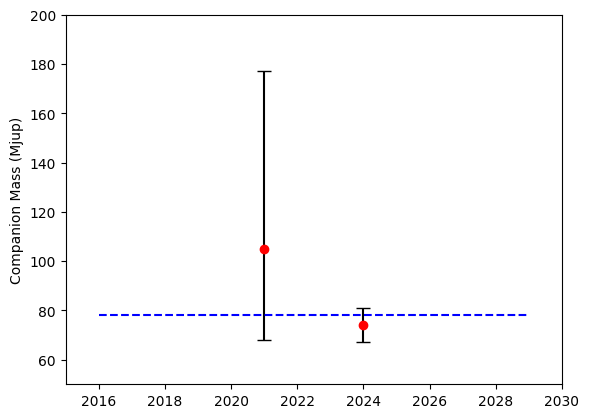

In [18]:
x = [2021, 2024]
y = [105.0, 73.9]
thresh = [78.0, 78.0]

y_min = [37, 6.9]
y_max = [72, 6.9]

plt.errorbar(x, y, yerr = [y_min, y_max], ls=' ', marker='o', color='red', capsize=5, capthick=1, ecolor='black')
plt.plot(list(np.arange(2016, 2030)), [78] * 14, color='blue', ls='--')
plt.ylabel('Companion Mass (Mjup)')
plt.ylim(50, 200)
plt.xlim(2015, 2030)

236230.73335962775
(15, 15)
[[Model]]
    (Model(gaussian2d, prefix='g_') + Model(constant, prefix='c_'))
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 370
    # data points      = 225
    # variables        = 6
    chi-square         = 2.8697e+12
    reduced chi-square = 1.3104e+10
    Akaike info crit   = 5247.55386
    Bayesian info crit = 5268.05047
    R-squared          = 0.96069470
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    g_centerx:    7.10579124 (init = 7)
    g_centery:    5.00054679 (init = 7)
    g_amplitude:  81516822.0 (init = 2774185)
    g_sigmax:     2.09553833 (init = 1)
    g_sigmay:     2.55150615 (init = 1)
    c_c:          268473.807 (init = 0)


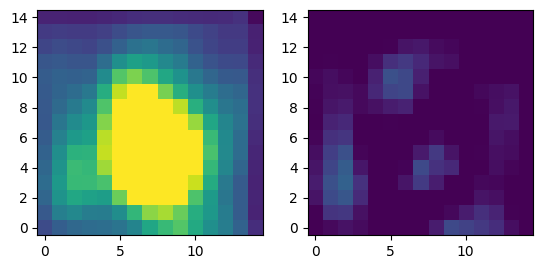

140667423.96297792


In [11]:
import numpy as np
from lmfit import Model, Parameters
from lmfit.models import Gaussian2dModel, ConstantModel
from astropy.io import fits


gModel = Gaussian2dModel(prefix='g_') + ConstantModel(prefix='c_')


def fitPrimary(x0, y0, im, radius=10, xIndex=None, yIndex=None,
               weight=None, mask=None,
               returnModel=False):
    """
    fit a 2d gaussian to the region of interest and return the fitted x and y
    """
    if xIndex is None:
        xIndex = np.arange(im.shape[1]).astype(int)
    if yIndex is None:
        yIndex = np.arange(im.shape[0]).astype(int)

    subXIndex, = np.where(np.abs(xIndex - x0) < radius)
    subYIndex, = np.where(np.abs(yIndex - y0) < radius)

    yyIndex, xxIndex = np.meshgrid(subYIndex, subXIndex,
                                   indexing='ij')
    yy, xx = np.meshgrid(yIndex[subYIndex], xIndex[subXIndex],
                         indexing='ij')

    subim = im[yyIndex.astype(int), xxIndex.astype(int)]

    if weight is None:
        subweight = np.ones_like(subim)
    else:
        subweight = weight[subYIndex, subXIndex]

    if mask is None:
        mask = np.zeros_like(subim)
    else:
        # if there are masked pixel, set the corresponding pixels' weight to 0
        weight[np.where(mask) != 0] = 0
    p = Parameters()
    p.add('g_centerx', value=x0)
    p.add('g_centery', value=y0)
    p.add('g_amplitude', value=np.nanmax(subim))
    p.add('g_sigmax', value=1, min=0)
    p.add('g_sigmay', value=1, min=0)
    p.add('c_c', value = 0)
    pFit = gModel.fit(subim, params=p, x=xx, y=yy, weights=subweight,
                      verbose=True,
                      method='powell',
                      nan_policy='omit')
    modelImage = np.zeros_like(im) 
    modelImage[yyIndex.astype(int), xxIndex.astype(int)] = pFit.best_fit.reshape(yy.shape) 

    print(pFit.fit_report())
    return pFit, modelImage

if __name__ == '__main__':
    _, star_img = starData('02_H')
    pFit, best_im = fitPrimary(7, 7, star_img, radius=8, returnModel=True)
    print(pFit.fit_report())
    # show the best model
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(ncols=2)
    # keep consistent range    
    vmin = 1e4
    vmax = 1e6
    axs[0].imshow(star_img, origin='lower', vmin=vmin, vmax=vmax)
    
    axs[1].imshow(star_img - best_im, origin='lower', vmin=vmin, vmax=vmax)
    plt.show()

    print(np.sum(best_im))

In [ ]:
# apply fitPrimary to H feb data
# same for Ks, other bands ...